<a href="https://colab.research.google.com/github/x110/DLToolboxImg/blob/master/NoduleSegmentationModel13.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Configuration

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
!ls

In [0]:
# Remove CUDA 9 completely

!apt-get --purge remove cuda nvidia* libnvidia-*
!apt-get remove cuda-*
!dpkg -l | grep cuda- | awk '{print $2}' | xargs -n1 dpkg --purge
!apt autoremove
!apt-get update

In [0]:
# Install CUDA 8

!wget https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1604/x86_64/cuda-repo-ubuntu1604_8.0.61-1_amd64.deb
!dpkg -i --force-overwrite cuda-repo-ubuntu1604_8.0.61-1_amd64.deb
!apt-get update
!apt-get install cuda-8-0

# install will fail, need to force dpkg to overwrite the configuration file

!wget http://archive.ubuntu.com/ubuntu/pool/main/m/mesa/libglx-mesa0_18.0.5-0ubuntu0~18.04.1_amd64.deb
!dpkg -i --force-overwrite libglx-mesa0_18.0.5-0ubuntu0~18.04.1_amd64.deb

!wget http://developer.download.nvidia.com/compute/cuda/repos/ubuntu1604/x86_64/nvidia-410_410.48-0ubuntu1_amd64.deb
!dpkg -i --force-overwrite nvidia-410_410.48-0ubuntu1_amd64.deb

!apt --fix-broken install
!apt-get install cuda-8-0

In [0]:
!pip uninstall -y numpy
!pip uninstall -y scipy
!pip install turicreate
# The worng version of MXNET will be installed.
!pip uninstall -y mxnet
!pip install scipy
# Instal CUDA8-compatible version of mxnet 1.1.0
!pip install mxnet-cu80==1.1.0

#  Load Data

In [0]:
PATH = "x110/"

In [0]:
!mkdir {PATH}
!mkdir {PATH+"Datasets"}
!mkdir {PATH+"Datasets/Dataset1/"}
!mkdir {PATH+"Datasets/Dataset1/processed/"}
!mkdir {PATH+"model"}

In [0]:
dataset_path = '/content/drive/My Drive/Datasets/Dataset5/processed/.'
model_path1 = "drive/My Drive/x110/model/model12/"
#model details
prefix1 = "jan09"
model_epoch=47

model_path2 = "drive/My Drive/x110/model/model13/"
prefix2 = "jan09"


In [0]:
epochs = 10
load_model = True
find_stats = False#True
bs = 100#64#34

In [0]:
!cp -a "{dataset_path}" {PATH+"Datasets/Dataset1/processed/"}

In [4]:
!mkdir x110/DLToolboxImg
!git clone https://github.com/x110/DLToolboxImg.git x110/DLToolboxImg

mkdir: cannot create directory ‘x110/DLToolboxImg’: File exists
fatal: destination path 'x110/DLToolboxImg' already exists and is not an empty directory.


# Settings

In [0]:
#Dataset Path 
interm_dir4 = PATH + "Datasets/Dataset1/processed/"
s = "2018_11_25"
train_data_path=interm_dir4+'train'+s+'pos.rec'
train_idx_path=interm_dir4+'train'+s+'pos.idx'
valid_data_path=interm_dir4+'valid'+s+'pos.rec'
valid_idx_path=interm_dir4+'valid'+s+'pos.idx'
test_data_path=interm_dir4+'test'+s+'pos.rec'
test_idx_path=interm_dir4+'test'+s+'pos.idx'

In [9]:
load_model

True

In [0]:
if load_model:
  drivefile = model_path1+prefix1+"-"+"{:04d}".format(model_epoch)+".params"
  drivefile2 = model_path1+prefix1+"-symbol.json"
  colabfile = PATH+"model/"+prefix1+"-"+"{:04d}".format(model_epoch)+".params"
  colabfile2 = PATH+"model/"+prefix1+"-symbol.json"

  !cp  "{drivefile}" {colabfile}
  !cp  "{drivefile2}" {colabfile2}


<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Configuration" data-toc-modified-id="Configuration-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Configuration</a></span></li><li><span><a href="#Preprocessing" data-toc-modified-id="Preprocessing-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Preprocessing</a></span><ul class="toc-item"><li><span><a href="#Find-mean-of-images" data-toc-modified-id="Find-mean-of-images-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Find mean of images</a></span></li><li><span><a href="#Find-variance-of-images" data-toc-modified-id="Find-variance-of-images-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Find variance of images</a></span></li></ul></li><li><span><a href="#Data-Iterator" data-toc-modified-id="Data-Iterator-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Data Iterator</a></span></li><li><span><a href="#Evaluation-Metric" data-toc-modified-id="Evaluation-Metric-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Evaluation Metric</a></span></li><li><span><a href="#Model-Architecture" data-toc-modified-id="Model-Architecture-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Model Architecture</a></span></li><li><span><a href="#Optimizer" data-toc-modified-id="Optimizer-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Optimizer</a></span><ul class="toc-item"><li><span><a href="#Find--learning-rate" data-toc-modified-id="Find--learning-rate-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Find  learning rate</a></span></li><li><span><a href="#Optimizer-Parameters" data-toc-modified-id="Optimizer-Parameters-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Optimizer Parameters</a></span></li></ul></li><li><span><a href="#Train-Model" data-toc-modified-id="Train-Model-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Train Model</a></span></li><li><span><a href="#Evaluate-Model" data-toc-modified-id="Evaluate-Model-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Evaluate Model</a></span></li></ul></div>

# Model Code

In [0]:
import sys
sys.path.insert(0,"x110/DLToolboxImg/src/")

In [0]:
import mynnet7 as nn
import pickle
import mxnet as mx
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [0]:
import mxnet as mx
import sys, os
import random
import time
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import numpy as np
import cv2
import pandas as pd
import re
from mxnet.io import DataIter
from mxnet.io import DataBatch
import pandas as pd
from scipy.ndimage.filters import gaussian_filter
from scipy.ndimage.interpolation import map_coordinates
from collections import namedtuple
import pickle

Batch = namedtuple('Batch', ['data'])

BATCH_SIZE,INPUT_SIZE_z,INPUT_SIZE_y, INPUT_SIZE_x = 8,32,32,32

class FileIter(DataIter):
    def __init__(self, path,path_idx,
                 data_name="data",
                 label_name="softmax_label",
                 batch_size=1,
                 do_augment=False,
                 random_flip=False,
                 random_rot=False,
                 random_elastic=False, 
                 mean_image=.28,
                 std_image = .28,
                 do_shuffle = True):

        
        random.seed(313)
        self.ind2=None
        self.do_shuffle = do_shuffle
        self.epoch = 0
        self.mean_image = mean_image
        self.std_image = std_image
        
        super(FileIter, self).__init__()
        self.batch_size = batch_size
        self.do_augment=do_augment
        self.random_flip = random_flip
        self.random_rot = random_rot
        self.random_elastic = random_elastic

        self.data_name = data_name
        self.label_name = label_name

        self.record = mx.recordio.MXIndexedRecordIO(path_idx, path, 'r')#mx.recordio.MXRecordIO(path, 'r')

        
        def readrecord(record):
            record.reset()
            num_data=0
            while True:
                item = record.read()
                num_data+=1
                if not item:
                    break
            return num_data-1
        
        
        self.num_data = readrecord(self.record)#len(open(self.flist_name, 'r').readlines())
        
        
        
        self.idx = self.shuffle_idx()
        self.cursor = -1
        self.cursor2 = -1
        self.ind = self.idx[0]
        self.record.reset()

        self.data, self.label = self._read()
        self.reset()
            
    def shuffle_idx(self):
        num_data = self.num_data//self.batch_size*self.batch_size
        idx = [i for i in range(num_data)]
        if self.do_shuffle:
            random.shuffle(idx)
        idx = np.array(idx)
        idx = idx.reshape(-1,self.batch_size)
        return idx
    
    def _read(self):
        """get two list, each list contains two elements: name and nd.array value"""
                
        data = {}
        label = {}

        dd = []
        ll = []
        
        if self.ind2 is None:
            ind = self.ind
        else:
            ind = self.ind2
            self.ind2=None
            
        for i in range(0, self.batch_size):
            
            item = self.record.read_idx(ind[i])            
            header, l = mx.recordio.unpack_img(item)
            
            d=header.label

            d=d.reshape((32,32,32))- self.mean_image
            d = d/self.std_image
            
            l=l.reshape((32,32,32))
            
            if self.random_elastic:            
              if random.randint(0, 100) > 50:
                d=np.array([elastic_transform(subd, 34, 4) for subd  in d])
                l=np.array([elastic_transform(subl, 34, 4) for subl  in l])

                
            data11=np.concatenate((d,l),axis=0)  
            

            if self.random_rot:
              if random.randint(0, 100) > 50:
                n,rows,cols = data11.shape
                rot =40* random.random()-20
                M = cv2.getRotationMatrix2D((cols/2,rows/2),rot,1)
                data11=np.array([cv2.warpAffine(d,M,(cols,rows))for d in data11])

            d,l=np.vsplit(data11,2)

            if self.random_flip:
            	l=l.reshape((32,32,32))
            	d,l = random_flip_img(d,l, horizontal_chance=0.5, vertical_chance=0.5)

            d = np.expand_dims(d, axis=0) 
            d = np.expand_dims(d, axis=0)
            l=l.reshape((32*32*32))
            l=l.astype(float)
            l = np.expand_dims(l, axis=0)



            dd.append(d)
            ll.append(l)

        d = np.vstack(dd)
        l = np.vstack(ll)
        data[self.data_name] = d
        label[self.label_name] = l
        res = list(data.items()), list(label.items())
        return res

    @property
    def provide_data(self):
        """The name and shape of data provided by this iterator"""
        res = [(k, tuple(list(v.shape[0:]))) for k, v in self.data]
        # print "data : " + str(res)
        return res

    @property
    def provide_label(self):
        """The name and shape of label provided by this iterator"""
        res = [(k, tuple(list(v.shape[0:]))) for k, v in self.label]
        return res
    

    def reset(self):
        self.cursor = -1
        self.cursor2 = -1
        self.record.reset()
        self.epoch += 1
        self.idx = self.shuffle_idx()
        


    def getpad(self):
        return 0

    def iter_next(self):
        self.cursor += self.batch_size
        self.cursor2 += 1
        num_data = self.num_data//self.batch_size*self.batch_size
            

        if self.cursor < self.num_data:
            self.ind = self.idx[self.cursor2]
            return True
        else:
            return False

    def eof(self):
        res = self.cursor >= self.num_data
        return res

    def next(self):
        """return one dict which contains "data" and "label" """
        if self.iter_next():
            self.data, self.label = self._read()
 
            res = DataBatch(data=[mx.nd.array(self.data[0][1])], label=[mx.nd.array(self.label[0][1])], pad=self.getpad(), index=None)

            return res
        else:
            raise StopIteration




In [0]:
from scipy.ndimage.filters import gaussian_filter
from scipy.ndimage.interpolation import map_coordinates
ELASTIC_INDICES = None  # needed to make it faster to fix elastic deformation per epoch.
def elastic_transform(image, alpha, sigma, random_state=None):
  global ELASTIC_INDICES
  shape = image.shape

  if ELASTIC_INDICES == None:
      if random_state is None:
          random_state = np.random.RandomState(1301)

      dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha
      dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha
      x, y = np.meshgrid(np.arange(shape[0]), np.arange(shape[1]))
      ELASTIC_INDICES = np.reshape(y + dy, (-1, 1)), np.reshape(x + dx, (-1, 1))
  return map_coordinates(image, ELASTIC_INDICES, order=1).reshape(shape)


In [0]:
def random_flip_img(X,Y, horizontal_chance=0.5, vertical_chance=0.5):
    import cv2
    flip_horizontal = False
    if random.random() < horizontal_chance:
        flip_horizontal = True

    flip_vertical = False
    if random.random() < vertical_chance:
        flip_vertical = True

    if not flip_horizontal and not flip_vertical:
        return (X,Y)

    flip_val = 1
    if flip_vertical:
        flip_val = -1 if flip_horizontal else 0

    Xaug = np.array([cv2.flip(x, flip_val) for x in X])
    Yaug = np.array([cv2.flip(x, flip_val) for x in Y])

    return (Xaug,Yaug)

In [0]:
import os
import math

In [0]:
# Set seed for reproducibility
mx.random.seed(42)

# Nodule Segmentation: Model

## Preprocessing

### Find mean of images

In [18]:
if find_stats:
    BATCH_SIZE=1
    train_iter=nn.FileIter(train_data_path,train_idx_path,batch_size=BATCH_SIZE,do_augment=True,mean_image=0,std_image=1)
    train_iter.reset()
    x_mean = np.zeros((32,32,32))
    for i,batch in enumerate(train_iter):
        X =  batch.data[0][0][0].asnumpy()
        x_mean+=X
    x_mean=np.mean(x_mean/i)
    # Saving the objects:
    with open(interm_dir4+'x_mean.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
        pickle.dump([x_mean], f)

else:
    with open(interm_dir4+'x_mean.pkl','rb') as f:  # Python 3: open(..., 'rb')
        x_mean = pickle.load(f)
x_mean#x_mean=0.2826227159416579

[0.28262271594165789]

In [0]:
x_mean=0.28

### Find variance of images

In [20]:
if find_stats: 
    BATCH_SIZE=1
    train_iter=nn.FileIter(train_data_path,train_idx_path,batch_size=BATCH_SIZE,do_augment=True,mean_image=0,std_image = 1)
    train_iter.reset()
    x_var = np.zeros((32,32,32))
    for i,batch in enumerate(train_iter):
        X =  (batch.data[0][0][0].asnumpy()-x_mean)**2
        x_var+=X
    #x_var=x_var/(i-1)
    #x_var#x_mean=.2815
    N = i*32*32*32
    x_var = np.sum(x_var)/(N-1)
    x_var#x_var = .07877
    x_std = np.sqrt(x_var)#x_std=.2807
    with open(interm_dir4+'x_std.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
        pickle.dump([x_std], f)
else:
    with open(interm_dir4+'x_std.pkl','rb') as f:  # Python 3: open(..., 'rb')
        x_std = pickle.load(f)
x_std#x_std=0.2817920662435274

[0.28179206624352737]

In [0]:
x_std = 0.28

## Data Iterator

In [22]:
BATCH_SIZE=bs
train_iter=FileIter(train_data_path,train_idx_path,batch_size=BATCH_SIZE,random_elastic = True,random_flip=True,random_rot=True,do_augment=True,mean_image=x_mean,std_image = x_std,do_shuffle=True)
input_shapes = dict(train_iter.provide_data+train_iter.provide_label)
print(input_shapes)

{'data': (100, 1, 32, 32, 32), 'softmax_label': (100, 32768)}


In [0]:
BATCH_SIZE=bs
valid_iter=FileIter(valid_data_path,valid_idx_path,batch_size=BATCH_SIZE,do_augment=False,mean_image=x_mean,std_image = x_std,do_shuffle=False)

In [0]:
train_iter.reset()
valid_iter.reset()

## Evaluation Metric

In [0]:
def dice_coef2(label, y):
    smooth = 1.
    label=mx.nd.array(label).as_in_context(mx.gpu(0))
    y=mx.nd.array(y).as_in_context(mx.gpu(0))
    intersection = mx.nd.sum(label*y)
    return ((2. * intersection + smooth) / (mx.nd.sum(label) +mx.nd.sum(mx.nd.abs(y)) + smooth))


In [0]:
def logloss2(label, y,w=[.9,.1]):
    smooth = 1.
    label=mx.nd.array(label).as_in_context(mx.gpu(0))
    y=mx.nd.array(y).as_in_context(mx.gpu(0))
    eps=1e-12
    return mx.nd.mean(-(w[0]*label*mx.nd.log(y+eps)+w[1]*(1-label)*mx.nd.log(1-y+eps)))

In [0]:
# ===============Evaluation metric(s)================= 
eval_metrics_1 =  mx.metric.CustomMetric(feval=logloss2)
eval_metrics_2 = mx.metric.CustomMetric(feval=nn.dice_coef2)
metric= mx.metric.CompositeEvalMetric()
for child_metric in [eval_metrics_1, eval_metrics_2]:
  metric.add(child_metric)

## Model Architecture

In [28]:
load_model

True

In [0]:
if load_model:
    network, arg_params, aux_params = mx.model.load_checkpoint(model_path1+prefix1 , model_epoch)

    # Binding
    exe = network.simple_bind(ctx=mx.gpu(0), **input_shapes)


    exe.copy_params_from(arg_params, aux_params)
    
    # get handle to input arrays
    arg_arrays = dict(zip(network.list_arguments(), exe.arg_arrays))
    data = arg_arrays[train_iter.provide_data[0][0]]
    label = arg_arrays[train_iter.provide_label[0][0]]
else:

    network = nn.get_net_319()
    init = mx.init.Normal(0.01) #note biases and gamma/beta are not affected

    # Binding
    exe = network.simple_bind(ctx=mx.gpu(), **input_shapes)
    # get handle to input arrays
    arg_arrays = dict(zip(network.list_arguments(), exe.arg_arrays))
    data = arg_arrays[train_iter.provide_data[0][0]]
    label = arg_arrays[train_iter.provide_label[0][0]]
    for name, arr in arg_arrays.items():
        if name not in input_shapes:
            init(name, arr)


In [0]:
epoch=0
arg={k:v for k, v in arg_arrays.items() if k not in input_shapes}
aux = dict(zip(network.list_auxiliary_states(), exe.aux_arrays))
mx.model.save_checkpoint(model_path2+prefix2, epoch, network, arg, aux)

# Nodule Segmentation: Model

## Optimizer

### Find  learning rate

In [0]:
find_learning_rate = True
b=.5
a=.01

nb=train_iter.num_data//train_iter.batch_size

if find_learning_rate:

  lrs = []
  loss = []
  
  sched=nn.lr_find(a,nb,end_lr=b)
  # We also need to create an optimizer for updating weights
  opt = mx.optimizer.SGD(
      learning_rate=a,
      momentum=0.9,
      wd=0.00001,
      lr_scheduler=sched)

  updater = mx.optimizer.get_updater(opt)
  for epoch in range(0,1):

      start = time.time()

      metric.reset()

      train_iter.reset()

      valid_iter.reset()

      sched.reset()

      sched.on_train_begin()


      for batch in train_iter:
          # Copy data to executor input. Note the [:].
          data[:] = batch.data[0]
          label[:] = batch.label[0]

          # Forward
          outputs=exe.forward(is_train=True)
          # Backward
          exe.backward()

          # Update
          for i, pair in enumerate(zip(exe.arg_arrays, exe.grad_arrays)):
              weight, grad = pair
              updater(i, grad, weight)   
          #metric.update(batch.label[0], exe.outputs[0])#
          metric.update(batch.label[0], exe.outputs[0])

          e=metric.get()
          e = dict(zip(e[0], e[1]))
  
          err_train=-e['dice_coef2'].asnumpy()[0]
          sched.on_batch_end(err_train)

      if epoch % 100== 0:       
          #print("do_checkpoint")
          arg={k:v for k, v in arg_arrays.items() if k not in input_shapes}
          aux = dict(zip(network.list_auxiliary_states(), exe.aux_arrays))
          #mx.model.save_checkpoint(prefix, epoch, network, arg, aux)


      #compute valid loss per epoch    
      metric.reset()
      for batch in valid_iter:        
          data[:] = batch.data[0]       
          label[:] = batch.label[0]
          # predict
          outputs = exe.forward(is_train=False)
          metric.update(batch.label[0], exe.outputs[0])
      e0=metric.get()
      e = dict(zip(e0[0], e0[1]))
      err_valid=-e['dice_coef2'].asnumpy()[0]
      end = time.time()
      print('time:',end-start,'Epoch:',epoch,'trainloss:',err_train,'validloss:',err_valid,'CE',outputs[1].asnumpy())
      for x,y in zip(e0[0],e0[1]):
        print(x,y[0].asnumpy()[0], end=", ", flush=True)
  lrs.extend(sched.lrs)
  loss.extend(sched.losses)



In [1]:
plt.figure()
plt.plot(lrs, loss,'*-')

NameError: ignored

In [0]:
network, arg_params, aux_params = mx.model.load_checkpoint(model_path2+prefix2 ,11)
exe.copy_params_from(arg_params, aux_params)

In [34]:
lrs[:10]

[0.019230769230769232,
 0.038461538461538464,
 0.057692307692307696,
 0.07692307692307693,
 0.09615384615384615,
 0.11538461538461539,
 0.1346153846153846,
 0.15384615384615385,
 0.17307692307692307,
 0.1923076923076923]

### Optimizer Parameters

In [0]:
#logfile = model_path2+"errorlogmodel8.csv"
logfile = "errorlogmodel10.csv"

In [36]:
import os
exists = os.path.isfile(logfile)
exists

False

In [0]:
#exists = False

In [0]:

col_names = ['epoch',
             'lr',
             'loss',
             'E1train',
             'E1valid',
             'E2train',
             'E2valid']
df = pd.DataFrame(columns=col_names)

if not exists:
  df.to_csv(logfile)

In [39]:
df = pd.read_csv(logfile, index_col=0)
df.head()

,epoch,lr,loss,E1train,E1valid,E2train,E2valid


In [0]:
import copy
#import math


def plot_schedule(schedule_fn, iterations=1500):
    # Iteration count starting at 1
    iterations = [i+1 for i in range(iterations)]
    lrs = [schedule_fn(i) for i in iterations]
    plt.scatter(iterations, lrs)
    plt.xlabel("Iteration")
    plt.ylabel("Learning Rate")
    plt.show()

class CosineAnnealingSchedule():
    def __init__(self, min_lr, max_lr, cycle_length):
        """
        min_lr: lower bound for learning rate (float)
        max_lr: upper bound for learning rate (float)
        cycle_length: iterations between start and finish (int)
        """
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.cycle_length = cycle_length
        
    def __call__(self, iteration):
        if iteration <= self.cycle_length:
            unit_cycle = (1 + math.cos(iteration * math.pi / self.cycle_length)) / 2
            adjusted_cycle = (unit_cycle * (self.max_lr - self.min_lr)) + self.min_lr
            return adjusted_cycle
        else:
            return self.min_lr
          
    
    
class TriangularSchedule():
    def __init__(self, min_lr, max_lr, cycle_length, inc_fraction=0.5):     
        """
        min_lr: lower bound for learning rate (float)
        max_lr: upper bound for learning rate (float)
        cycle_length: iterations between start and finish (int)
        inc_fraction: fraction of iterations spent in increasing stage (float)
        """
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.cycle_length = cycle_length
        self.inc_fraction = inc_fraction
        
    def __call__(self, iteration):
        if iteration <= self.cycle_length*self.inc_fraction:
            unit_cycle = iteration * 1 / (self.cycle_length * self.inc_fraction)
        elif iteration <= self.cycle_length:
            unit_cycle = (self.cycle_length - iteration) * 1 / (self.cycle_length * (1 - self.inc_fraction))
        else:
            unit_cycle = 0
        adjusted_cycle = (unit_cycle * (self.max_lr - self.min_lr)) + self.min_lr
        return adjusted_cycle

class CyclicalSchedule():
    def __init__(self, schedule_class, cycle_length, cycle_length_decay=1, cycle_magnitude_decay=1, **kwargs):
        """
        schedule_class: class of schedule, expected to take `cycle_length` argument
        cycle_length: iterations used for initial cycle (int)
        cycle_length_decay: factor multiplied to cycle_length each cycle (float)
        cycle_magnitude_decay: factor multiplied learning rate magnitudes each cycle (float)
        kwargs: passed to the schedule_class
        """
        self.schedule_class = schedule_class
        self.length = cycle_length
        self.length_decay = cycle_length_decay
        self.magnitude_decay = cycle_magnitude_decay
        self.kwargs = kwargs
    
    def __call__(self, iteration):
        cycle_idx = 0
        cycle_length = self.length
        idx = self.length
        while idx <= iteration:
            cycle_length = math.ceil(cycle_length * self.length_decay)
            cycle_idx += 1
            idx += cycle_length
        cycle_offset = iteration - idx + cycle_length
        
        schedule = self.schedule_class(cycle_length=cycle_length-6, **self.kwargs)
        return schedule(cycle_offset) * self.magnitude_decay**cycle_idx

In [0]:
epochs = 25
lr =.2#0.075#.01#.3#.02#.15#.34#.2#.01#.002

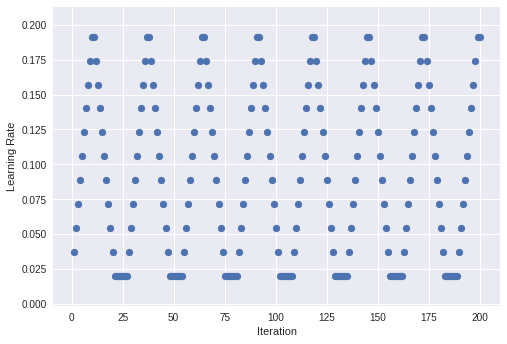

In [42]:
schedule = CyclicalSchedule(TriangularSchedule, min_lr=lr/10, max_lr=lr,
                            cycle_length=27, cycle_length_decay=1, cycle_magnitude_decay=1)
plot_schedule(schedule,iterations=200)

In [0]:
m1=.85
m2=.95

# We also need to create an optimizer for updating weights
# ===============Optimizer=================                        
opt = mx.optimizer.SGD(
    learning_rate=lr,momentum=m1,wd=0.00001)

updater = mx.optimizer.get_updater(opt)

updater.optimizer.lr_scheduler=schedule

In [0]:
#now = 50
#prefix = "jan09"
#err_validold = -.63

In [46]:
lrs=[]
ms=[]
lrold=-1
epoch_r  =now
epoch_r
Es_train=[]
Es_valid=[]
for epoch in range(epoch_r+1,epoch_r+epochs):
  
    start = time.time()
    
    ELASTIC_INDICES == None
    
    metric.reset()

    train_iter.reset()
    
    valid_iter.reset()
    

    for batch in train_iter:
        # Copy data to executor input. Note the [:].
        data[:] = batch.data[0]
        label[:] = batch.label[0]

        # Forward
        outputs=exe.forward(is_train=True)
        Es_train.append(outputs[1].asnumpy()[0])
        # Backward
        exe.backward()

        # Update
        for i, pair in enumerate(zip(exe.arg_arrays, exe.grad_arrays)):
            weight, grad = pair
            updater(i, grad, weight)   
        metric.update(batch.label[0], exe.outputs[0])#metric.update(label,p)
        if (opt.learning_rate-lrold)<0:
          opt.momentum=m2
          lrold = opt.learning_rate
        else: 
          opt.momentum=m1
          lrold=opt.learning_rate
        lrs.append(opt.learning_rate)
        ms.append(opt.momentum)
    e=metric.get()
    ed={}
    e_key,e_val = e
    for k,v in zip(e_key,e_val):
      ed[k]=v.asnumpy()[0]
    err_train=-ed['dice_coef2']
    err_train2=ed['logloss2']
    
    loss = outputs[1].asnumpy()[0] 
    
    if epoch % 5== 0:       
        #print("do_checkpoint")
        arg={k:v for k, v in arg_arrays.items() if k not in input_shapes}
        aux = dict(zip(network.list_auxiliary_states(), exe.aux_arrays))
        mx.model.save_checkpoint(model_path2+prefix2, epoch, network, arg, aux)
        

    #compute valid loss per epoch    
    metric.reset()
    for batch in valid_iter:        
        data[:] = batch.data[0]       
        label[:] = batch.label[0]
        # predict
        outputs = exe.forward(is_train=False)
        Es_valid.append(outputs[1].asnumpy()[0])
        metric.update(batch.label[0], exe.outputs[0])
    e=metric.get()
    ed={}
    e_key,e_val = e
    for k,v in zip(e_key,e_val):
      ed[k]=v.asnumpy()[0]
    err_valid=-ed['dice_coef2']
    err_valid2=ed['logloss2']
    
    if err_valid<err_validold:       
        #print("do_checkpoint")
        arg={k:v for k, v in arg_arrays.items() if k not in input_shapes}
        aux = dict(zip(network.list_auxiliary_states(), exe.aux_arrays))
        mx.model.save_checkpoint(model_path2+prefix2, epoch, network, arg, aux)
        err_validold = err_valid
    
    
    end = time.time()
    print('time:',end-start,'Epoch:',epoch,"/",epochs,"loss",loss,'trainloss:',err_train,'validloss:',err_valid,'trainloss2:',err_train2,'validloss2:',err_valid2)
    myCsvRow = [(epoch,opt.learning_rate,loss,err_train,err_valid,err_train2,err_valid2)]
    df = pd.DataFrame.from_records(myCsvRow,columns = col_names)
    df.to_csv(logfile, mode='a', header=False)
now=epoch
mx.model.save_checkpoint(model_path2+prefix2+'bst', epoch, network, arg, aux)


time: 113.66490650177002 Epoch: 1 / 25 loss -0.735171 trainloss: -0.641421 validloss: -0.616948 trainloss2: 0.165107 validloss2: 0.299709
time: 113.81673693656921 Epoch: 2 / 25 loss -0.791994 trainloss: -0.639087 validloss: -0.577624 trainloss2: 0.16459 validloss2: 0.280468
time: 113.73174381256104 Epoch: 3 / 25 loss -0.722574 trainloss: -0.63707 validloss: -0.590044 trainloss2: 0.171179 validloss2: 0.31499
time: 113.73012781143188 Epoch: 4 / 25 loss -0.792814 trainloss: -0.636106 validloss: -0.59424 trainloss2: 0.172816 validloss2: 0.242876
time: 113.81821537017822 Epoch: 5 / 25 loss -0.697302 trainloss: -0.620536 validloss: -0.553496 trainloss2: 0.157731 validloss2: 0.305675
time: 113.8294448852539 Epoch: 6 / 25 loss -0.740163 trainloss: -0.629297 validloss: -0.604909 trainloss2: 0.158167 validloss2: 0.228405
time: 113.75464224815369 Epoch: 7 / 25 loss -0.743511 trainloss: -0.635703 validloss: -0.621675 trainloss2: 0.155499 validloss2: 0.250893
time: 113.74836754798889 Epoch: 8 / 25 

In [0]:

plt.figure()
plt.plot(lrs)
plt.figure()
plt.plot(ms)


In [0]:
err_validold

-0.6310017